# 3rd demo: Supervised learning

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import zscore

## 1. Explore the data. Preprocessing.

In [2]:
shipdata = pd.read_csv("shipdata.txt", sep='\t')

In [3]:
shipdata.head()

,MMSI,Speed (knots),COG (degrees),Destination,Ship type,Gross tonnage,Length (m),Breadth (m)
0,636015204,10.1,64.3,Hamina,Cargo,3416,94.9,15.3
1,230182000,8.4,65.8,Hamina,Cargo,3978,1000.0,16.5
2,230601000,10.1,74.9,Hamina,Cargo,2280,82.6,12.3
3,636092755,9.2,74.6,Hamina,Cargo,8620,137.1,19.1
4,215058000,9.6,73.2,Hamina,Cargo,1905,87.9,11.4


In [4]:
# Count distinct values in teh column "Ship type"

print("Different ship types and their number:\n")

shipdata["Ship type"].value_counts()

Different ship types and their number:



Cargo     50
Tanker    48
Tug        9
Name: Ship type, dtype: int64

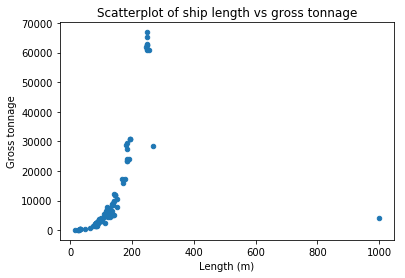

We clearly see one outlier with length of 1000m.

We plot again withtout the row where Length (m) == 1000:



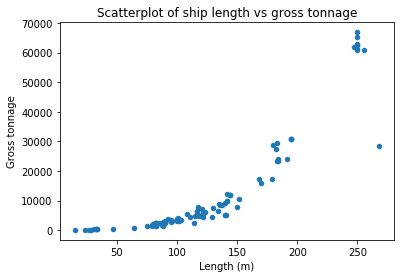

Now the spread looks better. The one datapoint in the far right might be an outlier, but the separation is not too big to be sure.


In [5]:
# Scatter plot of ship length vs gross tonnage

shipdata.plot("Length (m)", "Gross tonnage",kind="scatter");
plt.title("Scatterplot of ship length vs gross tonnage")
plt.show()

print("We clearly see one outlier with length of 1000m.\n\nWe plot again withtout the row where Length (m) == 1000:\n")
shipdata[shipdata["Length (m)"]!=1000.0].plot("Length (m)", "Gross tonnage",kind="scatter");
plt.title("Scatterplot of ship length vs gross tonnage")
plt.show()

print("Now the spread looks better. The one datapoint in the far right might be an outlier,",end="")
print(" but the separation is not too big to be sure.")

# delete the row from the original
shipdata=shipdata[shipdata["Length (m)"]!=1000.0]

In [6]:
# Join the dummy variable table of destinations to the end of the original dataframe

shipdata["Destination"] = pd.factorize(shipdata["Destination"])[0]

#shipdata_expanded = shipdata.join(pd.get_dummies(shipdata["Destination"]))

In [7]:
# Convert ship type and destination to string

shipdata["Ship type"] = shipdata["Ship type"].astype(str)
shipdata["Destination"] = shipdata["Destination"].astype(str)

In [8]:
# Z-score stadardization for speed

shipdata["Speed (knots)"] = shipdata["Speed (knots)"].apply(lambda x: (x - np.mean(shipdata["Speed (knots)"]))/np.std(shipdata["Speed (knots)"]) )

In [9]:
# Z-score stadardization for gross tonnage

shipdata["Gross tonnage"] = shipdata["Gross tonnage"].apply(lambda x: (x - np.mean(shipdata["Gross tonnage"]))/np.std(shipdata["Gross tonnage"]) )

In [10]:
# Z-score stadardization for length

shipdata["Length (m)"] = shipdata["Length (m)"].apply(lambda x: (x - np.mean(shipdata["Length (m)"]))/np.std(shipdata["Length (m)"]) )

In [11]:
# Z-score stadardization for breadth

shipdata["Breadth (m)"] = shipdata["Breadth (m)"].apply(lambda x: (x - np.mean(shipdata["Breadth (m)"]))/np.std(shipdata["Breadth (m)"]) )

## 2. Predict the ship type with the speed, destination, length, breadth and gross tonnage data using kNN classifier with k=3. Find an estimation for the classification accuracy using <font color=blue>random training and test sets</font>.

In [14]:
# Import NearestNeighbors from sklearn

from sklearn.neighbors import NearestNeighbors

In [23]:
#
# Create an array for the final test results
#

test_results = np.zeros(1000)

#
# Loop the process below 1000 times and record results to the array
#

for x in range(1000):

    # Randomize the original list
    # Since the type of ship probably affects its length and gross tonnage,
    # it is wise to sample separately from each type
    #
    # Randomize and separate by ship type

    randomsample_Cargo = shipdata[shipdata["Ship type"] == "Cargo"].sample(n=int(len(shipdata[shipdata["Ship type"] == "Cargo"])))
    randomsample_Tanker = shipdata[shipdata["Ship type"] == "Tanker"].sample(n=int(len(shipdata[shipdata["Ship type"] == "Tanker"])))
    randomsample_Tug = shipdata[shipdata["Ship type"] == "Tug"].sample(n=int(len(shipdata[shipdata["Ship type"] == "Tug"])))

    #
    # Pick first 70% of the lines for training... 
    #

    traindata = randomsample_Cargo[0:int(0.7*len(randomsample_Cargo))]
    traindata = traindata.append(randomsample_Tanker[0:int(0.7*len(randomsample_Tanker))])
    traindata = traindata.append(randomsample_Tug[0:int(0.7*len(randomsample_Tug))])
    traindata_type = traindata["Ship type"]

    #
    # ...and rest for testing
    #

    testdata = randomsample_Cargo[int(0.7*len(randomsample_Cargo)):]
    testdata = testdata.append(randomsample_Tanker[int(0.7*len(randomsample_Tanker)):])
    testdata = testdata.append(randomsample_Tug[int(0.7*len(randomsample_Tug)):])
    testdata_type = testdata["Ship type"]

    #
    # picking multiple columns tip from https://stackoverflow.com/a/48545159
    #

    traindata_crop = traindata.iloc[:,[1,3,5,6,7]]
    testdata_crop = testdata.iloc[:,[1,3,5,6,7]]

    #
    # From https://scikit-learn.org/stable/modules/neighbors.html#unsupervised-nearest-neighbors
    # first example of "1.6.1.1. Finding the Nearest Neighbors"
    #
    # Calculate for 3 nearest neighbors
    #

    nbrs = NearestNeighbors(n_neighbors=3, algorithm='ball_tree').fit(traindata_crop)
    distances, indices = nbrs.kneighbors(testdata_crop)

    #
    # Create table for test results
    #

    test_types = pd.DataFrame({"Ship type 1": range(len(indices)), "Ship type 2": range(len(indices)), "Ship type 3": range(len(indices))}, dtype = str)

    #
    # Insert the ship type of each nearest neighbor to the test_types array
    #

    for i in range (len(indices)):
        test_types["Ship type 1"][i] = traindata_type.iloc[indices[i][0]]
        test_types["Ship type 2"][i] = traindata_type.iloc[indices[i][1]]
        test_types["Ship type 3"][i] = traindata_type.iloc[indices[i][2]]

    #
    # Calculate the number of correct predictions and print results
    #
    # test_types.mode(axis=1)[i][0] picks the most frequent element of row i
    #

    array_1 = test_types.mode(axis=1)
    
    sum = 0

    for i in range (len(testdata)):
        if (array_1.iloc[i][0] == testdata_type.iloc[i]):
            sum = sum + 1

    test_results[x] = (sum/len(testdata))*100
    
    #
    # Progress counter for debugging and fun
    #
        
    if(x == 250 or x == 500 or x == 750):
        print(int(x/10),"% done.")
    if(x == 999):
        print("Done!")

25 % done.
50 % done.
75 % done.
Done!


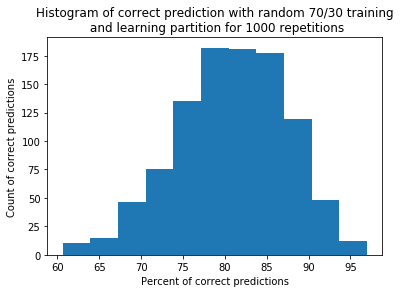

In [24]:
#plt.figure(figsize=(10,8))
plt.hist(test_results, bins = 11)
plt.xlabel("Percent of correct predictions")
plt.ylabel("Count of correct predictions")
plt.title("Histogram of correct prediction with random 70/30 training\n and learning partition for 1000 repetitions")
plt.show()

In [25]:
print("Minimum percent of correct predicions: ",np.min(test_results),"%")
print("Maximum percent of correct predictions: ",np.max(test_results),"%")
print("Mean percentage of correct predictions: ",np.mean(test_results),"%")

Minimum percent of correct predicions:  60.60606060606061 %
Maximum percent of correct predictions:  96.96969696969697 %
Mean percentage of correct predictions:  80.63636363636363 %


The peak of correct prediction is always ~80 percent (slightly depending on the partition of the test set) and most predictions are >60% correct.

## 3. Predict the ship type with the speed, destination, length, breadth and gross tonnage data using kNN classifier with k=3. Find an estimation of the classification accuracy using <font color=blue>leave-one-out</font>. Find the optimal value for k.

In [21]:
#
# Initialize result arrays
#

test_results_2 = np.zeros(20)
shipdata_type = shipdata["Ship type"]

#
# Loop for 1-20 number of nearest neighbors 
#

for z in range(1,21):
    
    test_types_2 = pd.DataFrame(index=range(len(shipdata)),columns=range(z), dtype = str)
    for k in range(len(shipdata)):


        #
        # Pick one row at a time to test
        #

        testdata_2 = shipdata[k:k+1]
        testdata_2_crop = shipdata[k:k+1].iloc[:,[1,3,5,6,7]]

        #
        # Create test set from all other rows
        #

        trainindices = np.delete(np.linspace(0,len(shipdata)-1,num=(len(shipdata)),dtype=int), k)
        traindata_2 = shipdata.iloc[list(trainindices),:]
        traindata_2_crop = shipdata.iloc[list(trainindices),[1,3,5,6,7]]

        #
        # From https://scikit-learn.org/stable/modules/neighbors.html#unsupervised-nearest-neighbors
        # first example of "1.6.1.1. Finding the Nearest Neighbors"
        #
        # Calculate for z nearest neighbors, z ranging from 1 to 20
        #
        
        nbrs_2 = NearestNeighbors(n_neighbors=z, algorithm='ball_tree').fit(traindata_2_crop)
        distances_2, indices_2 = nbrs_2.kneighbors(testdata_2_crop)

        #
        # Insert the ship type of each nearest neighbor to the test_types_2 array
        #

        for i in range(z):
            test_types_2.loc[k,i] = traindata_2["Ship type"].iloc[indices_2[0][i]]

        #
        # Calculate the number of correct predictions and store in test_results_2
        #

        array_2 = test_types_2.mode(axis=1)

        sum = 0

        for i in range (len(test_types_2)):
            if (array_2.iloc[i][0] == shipdata_type.iloc[i]):
                sum = sum + 1

        test_results_2[z-1] = (sum/len(test_types_2))*100
        
    #
    # Progress counter for debugging and fun
    #
        
    if(z == 5 or z == 10 or z == 15):
        print((z*5),"% done.")
    if(z == 20):
        print("Done!")
    

25 % done.
50 % done.
75 % done.
Done!


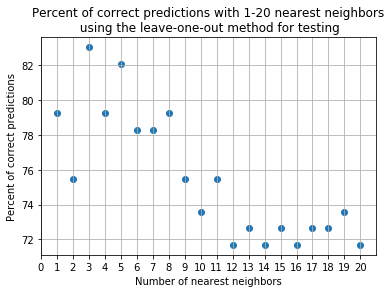

In [22]:
#plt.figure(figsize=(10,8))
plt.scatter(np.linspace(1,20,num=20),test_results_2)
plt.xticks(np.arange(0, 21, step=1))
plt.title("Percent of correct predictions with 1-20 nearest neighbors\n using the leave-one-out method for testing")
plt.grid(True)
plt.xlabel("Number of nearest neighbors")
plt.ylabel("Percent of correct predictions")
plt.show()

From the plot above, we see that the lower number of nearest neighbours provide the best results with leave-one-out method of testing. The best success rate can be found using 3 nearest neighbors with ~83%. Compared to the 70/30 testing in the previous section, this method gives more correct predictions, and there is no randomness in the success values.

## 4. Testing with training data

In [26]:
#
# Initialize result arrays
#

test_results_3 = np.zeros(20)
shipdata_type = shipdata["Ship type"]

#
# Loop for 1-20 number of nearest neighbors 
#

for z in range(1,21):
    
    test_types_3 = pd.DataFrame(index=range(len(shipdata)),columns=range(z), dtype = str)
    for k in range(len(shipdata)):


        #
        # Pick all the rows for testing...
        #

        testdata_3 = shipdata
        testdata_3_crop = shipdata.iloc[:,[1,3,5,6,7]]

        #
        # ..and for training
        #

        traindata_3 = shipdata
        traindata_3_crop = shipdata.iloc[:,[1,3,5,6,7]]

        #
        # From https://scikit-learn.org/stable/modules/neighbors.html#unsupervised-nearest-neighbors
        # first example of "1.6.1.1. Finding the Nearest Neighbors"
        #
        # Calculate for z nearest neighbors, z ranging from 1 to 20
        #
        
        nbrs_3 = NearestNeighbors(n_neighbors=z, algorithm='ball_tree').fit(traindata_3_crop)
        distances_3, indices_3 = nbrs_3.kneighbors(testdata_3_crop)

        #
        # Insert the ship type of each nearest neighbor to the test_types_2 array
        #

        for x in range(len(test_types_3)):
            for i in range(z):
                test_types_3.loc[x,i] = traindata_3["Ship type"].iloc[indices_3[x][i]]

        #
        # Calculate the number of correct predictions and store in test_results_2
        #

        array_3 = test_types_3.mode(axis=1)

        sum = 0

        for i in range (len(test_types_3)):
            if (array_3.iloc[i][0] == shipdata_type.iloc[i]):
                sum = sum + 1

        test_results_3[z-1] = (sum/len(test_types_3))*100
        
    #
    # Progress counter for debugging and fun
    #
        
    if(z == 5 or z == 10 or z == 15):
        print((z*5),"% done.")
    if(z == 20):
        print("Done!")

25 % done.
50 % done.
75 % done.
Done!


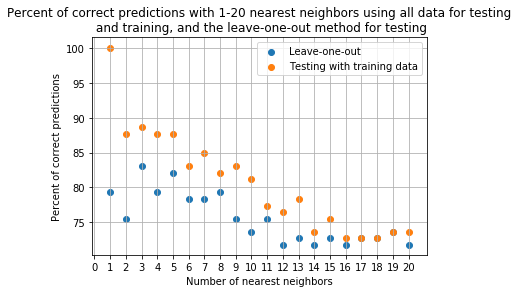

In [27]:
#plt.figure(figsize=(10,8))
plt.scatter(np.linspace(1,20,num=20),test_results_2, label="Leave-one-out");
plt.scatter(np.linspace(1,20,num=20),test_results_3, label="Testing with training data");
plt.xticks(np.arange(0, 21, step=1))
plt.title("Percent of correct predictions with 1-20 nearest neighbors using all data for testing\n and training, and the leave-one-out method for testing")
plt.grid(True)
plt.xlabel("Number of nearest neighbors")
plt.ylabel("Percent of correct predictions")
plt.legend()
plt.show()

As expected, the success rate for 1 neares neighbours when using training data as test data is 100%. After that, the success rate drops to ~88% and later follows rougly the same trend as with the leave-one-out method.

When testing with the training data, every number of nearest neighbors has the point itself which obviously raises the succes rate a bit. This affects the succes rate less the more nearest neighbours there are, as can be seen from the plot where the testing success starts to overlap with the leave-one-out method for large number of neighbors. Testing with the training data is also harmful if the data is clearly clustered by some category. With tight clusters, the prediction is almost always correct with the same data, and does not represent how the algorithm works with a random test subject from outside the train data.

In [31]:
[1,2,3]+[1,2,3]

[1, 2, 3, 1, 2, 3]

In [33]:
2:5

SyntaxError: illegal target for annotation (<ipython-input-33-08bb2cdb0f7b>, line 1)

In [36]:
list(range(2,6))+[2,5,6]

[2, 3, 4, 5, 2, 5, 6]